# My alternate EDA file, for additional testing

Read the other one first to get a marginally better idea as to why I'm doing what I do

* first three cells are practically the same as in the other one

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import WordNetLemmatizer

In [13]:
reviews = pd.read_csv("scraped_comments.csv").sample(n=500000, random_state=1)

In [14]:
reviews.drop_duplicates(subset="comment_id", keep="first", inplace=True)

reviews.dropna(subset=["comment"], inplace=True)
# drop rows containing only "No Comments" (default value assigned by RMP to a review that didn't enter a comment)
reviews = reviews[reviews["comment"] != "No Comments"]
# replace all comments with less than 5 words with a NaN
reviews["comment"] = reviews["comment"].apply(lambda x: x if len(x.split()) > 5 else None)
# drop rows containing NaN comment
reviews.dropna(subset=["comment"], inplace=True)

reviews.reset_index(drop=True, inplace=True)

# Figuring out how to remove HTML codes from comments
ie. `&quot;` appears quite a bit as the HTML encoding for a quotation mark (`"`), removing it will be quite helpful in ensuring data remains clean

In [15]:
reviews_html = reviews[reviews["comment"].str.contains('&([a-zA-z]+|#\d+);')]
reviews_html = reviews_html.loc[:, ["comment"]]
reviews_html.head()

C:\Users\ethan\AppData\Local\Temp\ipykernel_24264\1115318851.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  reviews_html = reviews[reviews["comment"].str.contains('&([a-zA-z]+|#\d+);')]


,comment
17,The &quot;Whip&quot; is and always be a legend.
32,I have never been treated this badly for askin...
76,On a facebook picture caption [of our 313 clas...
81,most people can not understand him. half the t...
108,"This guy is just an ass, he thinks that he hon..."


In [16]:
test_remove_html = re.sub('&([a-zA-z]+|#\d+);', "", reviews_html["comment"][17])
test_remove_html

'The Whip is and always be a legend.'

Back on track, trying to lemmatize and remove stopwords, but this one takes significantly longer (50+ times as long).

** the only difference is line 5: `spacy.load("en_core_web_md")` in this file vs. `English()` in the other

*In exchange, we'll see the results are slightly better in this file tbh*

In [17]:
import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load("en_core_web_md")
no_stop_words = []

for i in range(reviews.shape[0]):
    text = reviews["comment"][i]
    doc = nlp(text)

    token_list = []
    for token in doc:
        token_list.append(token.lemma_)
    
    filtered_sent = []
    for word in token_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sent.append(word)
    
    no_stop_words.append(" ".join(filtered_sent))


In [18]:
"""
nlp = spacy.load("en_core_web_md")
reviews["tokens"] = reviews["comment"].apply(lambda x: nlp(x))
reviews["lemma_tokens"] = reviews["tokens"].apply(lambda x: " ".join([token.lemma_ for token in x if token not in spacy.lang.en.stop_words.STOP_WORDS]))
"""

'\nnlp = spacy.load("en_core_web_md")\nreviews["tokens"] = reviews["comment"].apply(lambda x: nlp(x))\nreviews["lemma_tokens"] = reviews["tokens"].apply(lambda x: " ".join([token.lemma_ for token in x if token not in spacy.lang.en.stop_words.STOP_WORDS]))\n'

In [19]:
# removing non-alphabetic characters (may want to keep numbers, will deal with that later)
comments_proper = []

for i in range(reviews.shape[0]):
    review = no_stop_words[i]
    review = re.sub('[^a-zA-Z\s]+', ' ', review)
    review = re.sub('\s+', ' ', review)             # get rid of excess whitespace generated by spaCy's less-than-ideal tokenization
    review = review.lower()                         # lowercase review for uniformity
    comments_proper.append(review)

comments = pd.Series(comments_proper, copy=False)
comments

0         keith good afraid honest opinion grading paper...
1         lankau great class fun hilarious prepared stud...
2         hate second life sit class intelligent man ide...
3         crazy man grading system know grade tell stude...
4         teacher bad entire schooling career rude belit...
                                ...                        
450449    sound angry face right worth want work hard fu...
450450    enthusiastic class talk class ll set recommend...
450451    good professor knowledgeable helpful like fact...
450452    guy awful follow syllabus incredibly disorgani...
450453    dr coles nice class easy learn talk entire tim...
Length: 450454, dtype: object

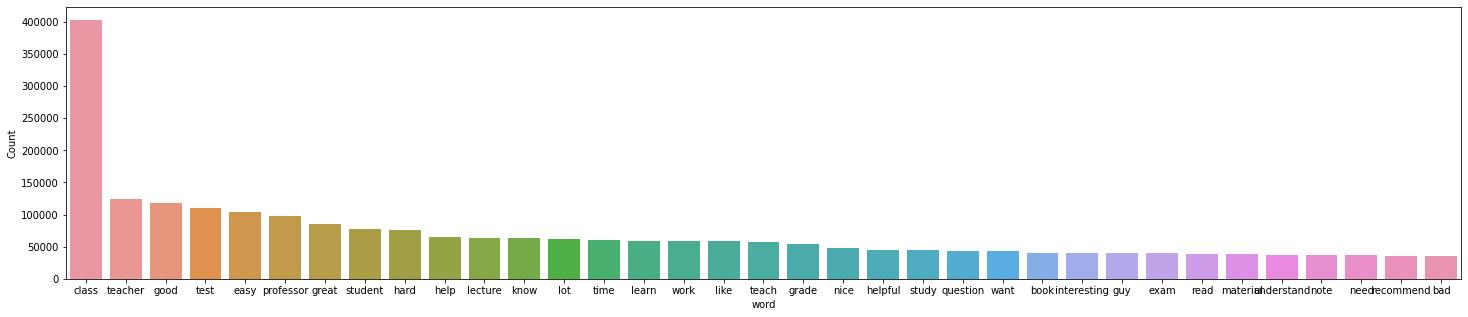

In [20]:
from nltk import FreqDist

%matplotlib inline
def freq_words(x, terms=30):        # function to plot most frequent words
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_words(comments, terms=35)

notice how above graph doesn't include `nt` and `quot` towards the end like the most frequent words in the other file

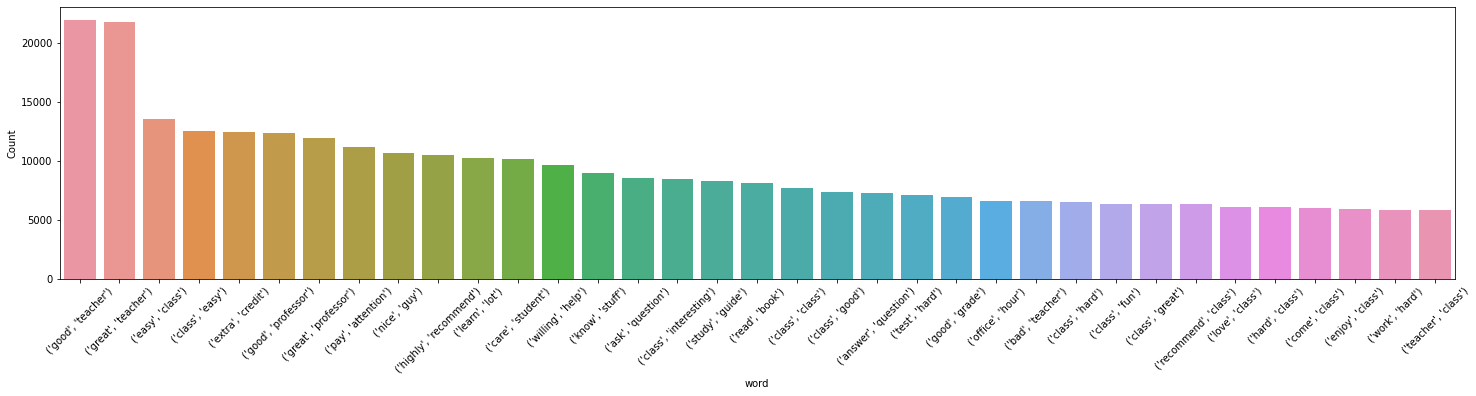

In [21]:
%matplotlib inline
def freq_bigrams(x, terms=30):        # function to plot most frequent words
    all_words = " ".join([text for text in x])
    all_words = all_words.split()

    bgs = nltk.bigrams(all_words)
    fdist = FreqDist(bgs)
    words_df = pd.DataFrame({"word":list(fdist.keys()), "count":list(fdist.values())})

    d = words_df.nlargest(columns="count", n=terms)
    plt.figure(figsize=(25,5))
    plt.xticks(rotation=45)
    ax = sns.barplot(data=d, x="word", y="count")
    ax.set(ylabel="Count")
    plt.show()

freq_bigrams(comments, terms=35)